# 部分依賴圖 (Partial Dependence Plots)

## 介紹
Feature Importance 顯示了哪些變量對預測影響最大，而Partial Dependence Plots則顯示了一個特徵如何影響預測結果。

一般這對於回答以下問題非常有用：
- 在控制其他房屋特徵的情況下，經度和緯度對房價有何影響？換句話說，不同地區的相似房屋價格如何？
- 兩組人群之間預測的健康差異是由於飲食差異還是其他因素？

如果您熟悉線性或邏輯回歸模型，Partial Dependence Plots 可以類似於這些模型中的係數進行解釋。不過，Partial Dependence Plots 在複雜模型中可以捕捉到比簡單模型係數更複雜的模式。如果您不熟悉線性或邏輯回歸，不必擔心這個比較。

## 運作原理
與 Permutation Importance 一樣，Partial Dependence Plots 是在模型擬合後計算的。模型擬合於未經人工操縱的真實數據。

以我們的足球示例為例，球隊在許多方面可能有所不同。他們的傳球數量、射門次數、進球數量等。乍看之下，似乎難以解開這些特徵的影響。

為了了解Partial Dependence Plots如何分離每個特徵的影響，我們從考慮單行數據開始。例如，該數據行可能代表一支控球率為50%、進行了100次傳球、射門10次並進了1球的球隊。

我們將使用擬合的模型來預測結果（球員贏得「最佳球員」的概率）。但我們反覆更改一個變量的值來進行一系列預測。我們可以預測如果球隊的控球率只有40%時的結果。然後預測控球率為50%時的結果。再預測控球率為60%時的結果。以此類推。我們追踪從小值到大值（水平軸）的控球率變化時的預測結果（垂直軸）。

在這個描述中，我們只使用了一行數據。特徵之間的互動可能會導致單行數據的圖表不典型。因此，我們用原始數據集中的多行數據重複這個預測實驗，並在垂直軸上繪製平均預測結果。

## Partial Dependence Plots 步驟

1. **模型擬合**：首先，我們使用真實數據擬合模型。這些數據沒有經過人工操縱，確保模型能夠學習數據中的真實模式。
  
2. **選擇特徵**：我們選擇一個需要分析的特徵，並保持數據集中其他特徵的數值不變。

3. **生成預測**：我們對選定的特徵進行一系列變化，每次變化後都生成一個預測結果。例如，我們可以逐漸增加或減少特徵的值，觀察預測結果的變化。

4. **計算平均值**：由於單一數據列可能不具代表性，我們在多個數據列上重複上述步驟，並計算這些預測結果的平均值。

5. **繪製圖表**：最終，我們將特徵的不同值與對應的平均預測結果繪製成圖表，這就是部分依賴圖。



## 範例
本筆記我們將展示幾個示例，解釋這些圖的解釋方式，然後回顧生成這些圖的代碼。

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

data = pd.read_csv('./FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

Our first example uses a decision tree, which you can see below. In practice, you'll use more sophisticated models for real-world applications.

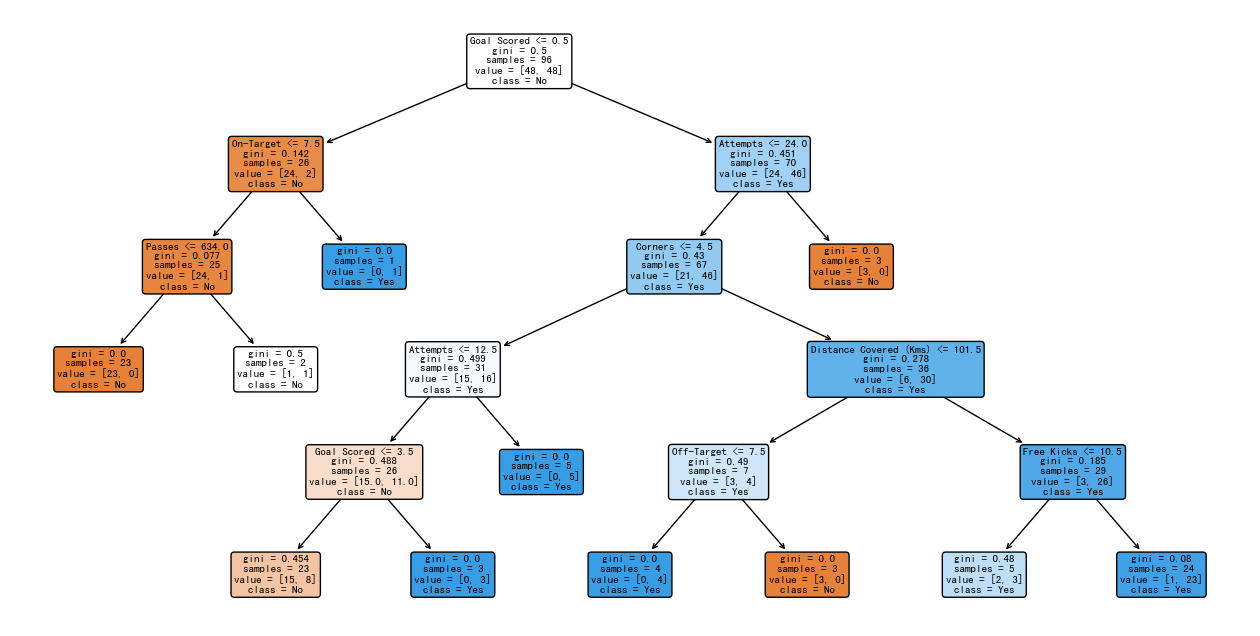

In [14]:
from sklearn import tree
import graphviz

plt.figure(figsize=(16,8))
tree.plot_tree(tree_model,rounded=True,filled=True, feature_names=feature_names, class_names=["No", "Yes"])
plt.show()

決策樹解讀:

節點中的頂部顯示其分割準則。
底部的一對值分別顯示在該樹節點中的數據點的目標值為 False 和 True 的計數。

## 探討特徵數值變化對輸出趨勢上的相關性

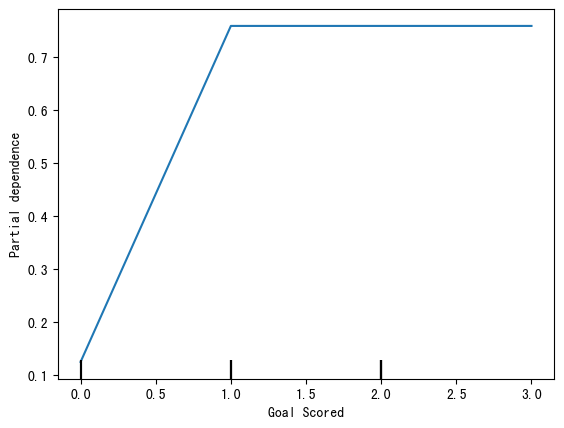

In [24]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Create and plot the data
disp1 = PartialDependenceDisplay.from_estimator(tree_model, val_X, ['Goal Scored'])
plt.show()

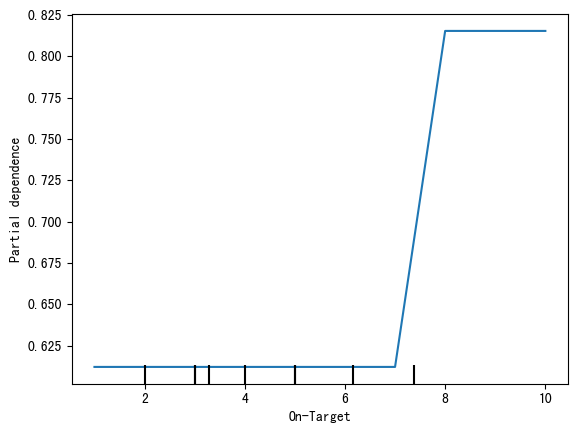

In [22]:
# Create and plot the data
feature_to_plot = 'On-Target'
disp1 = PartialDependenceDisplay.from_estimator(tree_model, val_X, [feature_to_plot])
plt.show()

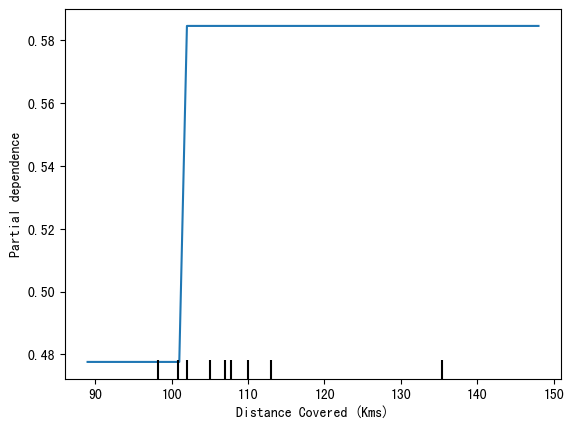

In [23]:
feature_to_plot = 'Distance Covered (Kms)'
disp2 = PartialDependenceDisplay.from_estimator(tree_model, val_X, [feature_to_plot])
plt.show()


y 軸被解釋為相較於 baseline 或最左邊的值的預測變化。

從這張特定的圖表中，我們看到進一個球會大大增加你獲得「全場最佳球員」的機會。但是，額外的進球似乎對預測的影響不大。


### 部分依賴圖的優點
- **解釋性強**：部分依賴圖提供了直觀的可視化，幫助我們理解特徵如何影響模型的預測結果。
- **應用廣泛**：無論是回歸模型還是分類模型，都可以使用部分依賴圖來分析特徵的影響。
- **捕捉複雜模式**：相比簡單模型的係數，部分依賴圖能夠捕捉到更複雜的非線性關係。

## 2D Partial Dependence Plots

如果你對特徵之間的交互感興趣，2D 部分依賴圖也很有用。

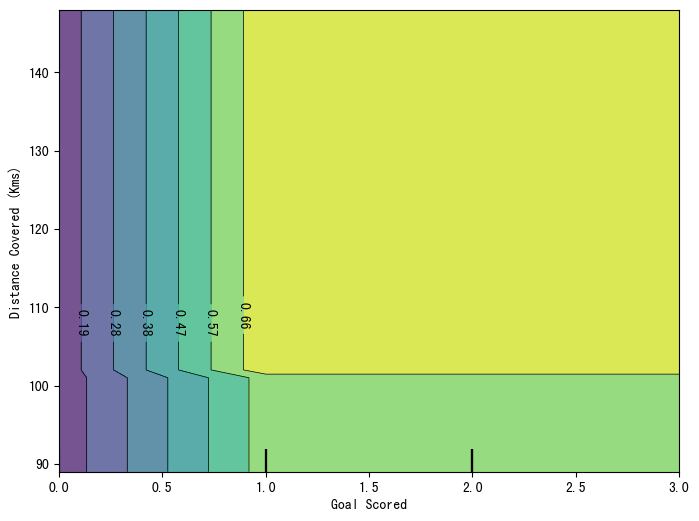

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('Goal Scored', 'Distance Covered (Kms)')]
# Similar to previous PDP plot except we use tuple of features instead of single feature
disp4 = PartialDependenceDisplay.from_estimator(tree_model, val_X, f_names, ax=ax)
plt.show()


此圖顯示了在進球數和推進距離組合下的預測。

例如，當一支球隊至少進一個球且總跑動距離接近100公里時，我們看到最高的預測。如果他們沒有進球，跑動距離無關緊要。

但如果他們有進球，距離可以影響預測。請確保你也能從2D部分依賴圖中洞察到這一現象!!